# This notebook implements sleeper agent attack

In this notebook, we will learn how to use ART to run a Hidden Trigger Backdoor Attack Sleeper Agent poisoning attack on a neural network trained with Pytorch. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/pdf/2106.08970.pdf) by Hossein Souri, et. al. 2021.

In [1]:
import math
from tqdm import trange
import numpy as np
import os, sys
import pdb
from PIL import Image
from numpy import asarray
from skimage.transform import resize
import random
from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10
from torchvision.models.resnet import BasicBlock, Bottleneck
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torch.nn.functional as F

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Data Normalization and Substitute Model Training 

In [3]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

patch_size = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img = Image.open('trigger_10.png')
numpydata = asarray(img)
patch = resize(numpydata, (patch_size,patch_size,3))
patch = (patch-mean)/(std+1e-7)
x_train_orig = np.copy(x_train)

In [4]:
def testAccuracy(model, test_loader):
    model_was_training = model.training
    model.eval()
    accuracy = 0.0
    total = 0.0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    if model_was_training:
        model.train()
    return(accuracy)

In [5]:
def create_model(x_train, y_train, x_test=None, y_test=None, num_classes=10, batch_size=128, epochs=25):
    initial_conv = [3, 1, 1]
    model = torchvision.models.ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    
    # Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    model.to(device)

    x_train = np.transpose(x_train, [0, 3,1,2])
    y_train = np.argmax(y_train, axis=1)
    x_tensor = torch.tensor(x_train, dtype=torch.float32, device=device) # transform to torch tensor
    y_tensor = torch.tensor(y_train, dtype=torch.long, device=device)
    
    x_test = np.transpose(x_test, [0, 3,1,2])
    y_test = np.argmax(y_test, axis=1)
    x_tensor_test = torch.tensor(x_test, dtype=torch.float32, device=device) # transform to torch tensor
    y_tensor_test = torch.tensor(y_test, dtype=torch.long, device=device)

    dataset_train = TensorDataset(x_tensor,y_tensor) # create your datset
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size)

    dataset_test = TensorDataset(x_tensor_test,y_tensor_test) # create your datset
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

    for epoch in trange(epochs):
        running_loss = 0.0
        total = 0
        accuracy = 0
        for i, data in enumerate(dataloader_train, 0):
            inputs, labels = data
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            # _, predicted = torch.max(outputs.data, 1)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            running_loss += loss.item()
        train_accuracy = (100 * accuracy / total)
        print("Epoch %d train accuracy: %f" % (epoch, train_accuracy))
        test_accuracy = testAccuracy(model, dataloader_test)
        print("Final test accuracy: %f" % test_accuracy)
    return model, loss_fn, optimizer

# Train Substitute Model for Attack

In [6]:
model_path = "cifar10-resnet18-pytorch.pth"
if not os.path.exists(model_path):
    model, loss_fn, optimizer = create_model(x_train, y_train,x_test=x_test,y_test=y_test,epochs=80)
    torch.save(model.state_dict(), model_path)
else:
    print("Pretrained model exists")
    model, loss_fn, optimizer = create_model(x_train, y_train,x_test=x_test,y_test=y_test,epochs=0)
    model.load_state_dict(torch.load(model_path))

Pretrained model exists


0it [00:00, ?it/s]


# Define Source and Target Class

In [7]:
class_source = 0
class_target = 1
K = 1000

# Select Triggers from Source Class and helper functions for calculating Success Rate

In [8]:
model_art = PyTorchClassifier(model, input_shape=x_train.shape[1:], loss=loss_fn, optimizer=optimizer, nb_classes=10)
from art.utils import to_categorical
from art.attacks.poisoning.sleeper_agent_attack import SleeperAgentAttack

def select_trigger_train(x_train,y_train,K,class_source,class_target):
    x_train_ = np.copy(x_train)
    index_source = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
    index_target = np.where(y_train.argmax(axis=1)==class_target)[0]
    x_trigger = x_train_[index_source]
    y_trigger  = to_categorical([class_target], nb_classes=10)
    y_trigger = np.tile(y_trigger,(len(index_source),1))
    return x_trigger,y_trigger,index_target
   

# Generate Poison Images through attack 

In [9]:
x_trigger,y_trigger,index_target = select_trigger_train(x_train,y_train,K,class_source,class_target)
result_original = model_art.predict(torch.tensor(np.transpose(x_trigger, [0, 3,1,2]), dtype=torch.float32))

In [10]:
attack = SleeperAgentAttack(model_art,
                                percent_poison=0.10,
                                max_trials=1,
                                max_epochs=250,
                                learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [250, 350, 400, 430, 460]),
                                clip_values=(min_,max_),
                                epsilon=16/255 * (max_ - min_),
                                batch_size=500,
                                verbose=1,
                                indices_target=index_target,
                                patching_strategy="random",
                                selection_strategy="max-norm",
                                patch=patch,
                                retraining_factor = 4,
                                model_retrain = True,
                                model_retraining_epoch = 80,
                                class_source = class_source,
                                class_target = class_target
                           )
x_poison, y_poison = attack.poison(x_trigger,y_trigger,x_train,y_train,x_test,y_test) 
indices_poison = attack.get_poison_indices()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0 train accuracy: 29.892
Epoch 5 train accuracy: 74.448
Epoch 10 train accuracy: 82.44
Epoch 15 train accuracy: 85.766
Epoch 20 train accuracy: 87.166
Epoch 25 train accuracy: 88.046
Epoch 30 train accuracy: 88.662
Epoch 35 train accuracy: 88.564
Epoch 40 train accuracy: 89.03
Epoch 45 train accuracy: 89.338
Epoch 50 train accuracy: 89.708
Epoch 55 train accuracy: 89.7
Epoch 60 train accuracy: 89.918
Epoch 65 train accuracy: 89.888
Epoch 70 train accuracy: 90.142
Epoch 75 train accuracy: 90.216
Epoch 79 train accuracy: 90.026
Final test accuracy: 71.52


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0 train accuracy: 35.046
Epoch 5 train accuracy: 75.722
Epoch 10 train accuracy: 83.152
Epoch 15 train accuracy: 86.014
Epoch 20 train accuracy: 87.686
Epoch 25 train accuracy: 88.368
Epoch 30 train accuracy: 88.784
Epoch 35 train accuracy: 88.914
Epoch 40 train accuracy: 89.35
Epoch 45 train accuracy: 89.624
Epoch 50 train accuracy: 89.754
Epoch 55 train accuracy: 89.784
Epoch 60 train accuracy: 89.868
Epoch 65 train accuracy: 89.896
Epoch 70 train accuracy: 89.806
Epoch 75 train accuracy: 90.332
Epoch 79 train accuracy: 90.364
Final test accuracy: 70.05


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0 train accuracy: 36.192
Epoch 5 train accuracy: 76.228
Epoch 10 train accuracy: 83.746
Epoch 15 train accuracy: 86.546
Epoch 20 train accuracy: 87.886
Epoch 25 train accuracy: 88.464
Epoch 30 train accuracy: 89.22
Epoch 35 train accuracy: 89.27
Epoch 40 train accuracy: 89.358
Epoch 45 train accuracy: 89.276
Epoch 50 train accuracy: 89.668
Epoch 55 train accuracy: 89.824
Epoch 60 train accuracy: 90.074
Epoch 65 train accuracy: 90.132
Epoch 70 train accuracy: 90.46
Epoch 75 train accuracy: 90.154
Epoch 79 train accuracy: 89.966
Final test accuracy: 70.96


  0%|          | 0/64 [00:00<?, ?it/s]

Best B-score: 0.020038366317749023


# Success Rate on Train Triggers

In [11]:
model_poisoned, loss_fn, optimizer = create_model(x_poison,y_poison,x_test=x_test,y_test=y_test,epochs=80)
model_poisoned.eval()

  0%|                                                                                                                                                                                                                                   | 0/80 [00:00<?, ?it/s]

Epoch 0 train accuracy: 29.724000


  1%|██▋                                                                                                                                                                                                                        | 1/80 [00:06<09:12,  6.99s/it]

Final test accuracy: 46.630000
Epoch 1 train accuracy: 49.818000


  2%|█████▍                                                                                                                                                                                                                     | 2/80 [00:13<08:52,  6.83s/it]

Final test accuracy: 55.080000
Epoch 2 train accuracy: 59.370000


  4%|████████▏                                                                                                                                                                                                                  | 3/80 [00:20<08:41,  6.78s/it]

Final test accuracy: 61.350000
Epoch 3 train accuracy: 66.124000


  5%|██████████▉                                                                                                                                                                                                                | 4/80 [00:27<08:33,  6.75s/it]

Final test accuracy: 65.690000
Epoch 4 train accuracy: 70.826000


  6%|█████████████▋                                                                                                                                                                                                             | 5/80 [00:33<08:24,  6.73s/it]

Final test accuracy: 66.210000
Epoch 5 train accuracy: 74.058000


  8%|████████████████▍                                                                                                                                                                                                          | 6/80 [00:40<08:17,  6.72s/it]

Final test accuracy: 67.360000
Epoch 6 train accuracy: 76.326000


  9%|███████████████████▏                                                                                                                                                                                                       | 7/80 [00:47<08:09,  6.71s/it]

Final test accuracy: 65.490000
Epoch 7 train accuracy: 78.220000


 10%|█████████████████████▉                                                                                                                                                                                                     | 8/80 [00:53<08:02,  6.70s/it]

Final test accuracy: 68.750000
Epoch 8 train accuracy: 79.804000


 11%|████████████████████████▋                                                                                                                                                                                                  | 9/80 [01:00<07:55,  6.69s/it]

Final test accuracy: 67.940000
Epoch 9 train accuracy: 81.376000


 12%|███████████████████████████▎                                                                                                                                                                                              | 10/80 [01:07<07:47,  6.69s/it]

Final test accuracy: 67.120000
Epoch 10 train accuracy: 82.274000


 14%|█████████████████████████████▉                                                                                                                                                                                            | 11/80 [01:13<07:41,  6.68s/it]

Final test accuracy: 67.780000
Epoch 11 train accuracy: 83.462000


 15%|████████████████████████████████▋                                                                                                                                                                                         | 12/80 [01:20<07:33,  6.67s/it]

Final test accuracy: 68.370000
Epoch 12 train accuracy: 83.914000


 16%|███████████████████████████████████▍                                                                                                                                                                                      | 13/80 [01:27<07:26,  6.67s/it]

Final test accuracy: 68.680000
Epoch 13 train accuracy: 84.984000


 18%|██████████████████████████████████████▏                                                                                                                                                                                   | 14/80 [01:33<07:19,  6.66s/it]

Final test accuracy: 69.400000
Epoch 14 train accuracy: 85.254000


 19%|████████████████████████████████████████▉                                                                                                                                                                                 | 15/80 [01:40<07:12,  6.66s/it]

Final test accuracy: 67.310000
Epoch 15 train accuracy: 85.756000


 20%|███████████████████████████████████████████▌                                                                                                                                                                              | 16/80 [01:47<07:06,  6.66s/it]

Final test accuracy: 69.550000
Epoch 16 train accuracy: 86.376000


 21%|██████████████████████████████████████████████▎                                                                                                                                                                           | 17/80 [01:53<06:59,  6.66s/it]

Final test accuracy: 69.020000
Epoch 17 train accuracy: 86.896000


 22%|█████████████████████████████████████████████████                                                                                                                                                                         | 18/80 [02:00<06:52,  6.66s/it]

Final test accuracy: 68.620000
Epoch 18 train accuracy: 86.700000


 24%|███████████████████████████████████████████████████▊                                                                                                                                                                      | 19/80 [02:07<06:46,  6.66s/it]

Final test accuracy: 69.250000
Epoch 19 train accuracy: 87.094000


 25%|██████████████████████████████████████████████████████▌                                                                                                                                                                   | 20/80 [02:13<06:38,  6.64s/it]

Final test accuracy: 68.500000
Epoch 20 train accuracy: 87.270000


 26%|█████████████████████████████████████████████████████████▏                                                                                                                                                                | 21/80 [02:20<06:30,  6.62s/it]

Final test accuracy: 68.920000
Epoch 21 train accuracy: 87.816000


 28%|███████████████████████████████████████████████████████████▉                                                                                                                                                              | 22/80 [02:26<06:23,  6.61s/it]

Final test accuracy: 68.920000
Epoch 22 train accuracy: 87.782000


 29%|██████████████████████████████████████████████████████████████▋                                                                                                                                                           | 23/80 [02:33<06:16,  6.60s/it]

Final test accuracy: 69.370000
Epoch 23 train accuracy: 87.854000


 30%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 24/80 [02:40<06:09,  6.60s/it]

Final test accuracy: 69.940000
Epoch 24 train accuracy: 87.942000


 31%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 25/80 [02:46<06:02,  6.59s/it]

Final test accuracy: 70.660000
Epoch 25 train accuracy: 88.484000


 32%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 26/80 [02:53<05:55,  6.59s/it]

Final test accuracy: 69.910000
Epoch 26 train accuracy: 88.310000


 34%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 27/80 [02:59<05:49,  6.59s/it]

Final test accuracy: 69.980000
Epoch 27 train accuracy: 88.832000


 35%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 28/80 [03:06<05:42,  6.59s/it]

Final test accuracy: 69.320000
Epoch 28 train accuracy: 88.428000


 36%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 29/80 [03:13<05:35,  6.59s/it]

Final test accuracy: 69.230000
Epoch 29 train accuracy: 88.818000


 38%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 30/80 [03:19<05:29,  6.59s/it]

Final test accuracy: 69.860000
Epoch 30 train accuracy: 88.892000


 39%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 31/80 [03:26<05:22,  6.59s/it]

Final test accuracy: 70.050000
Epoch 31 train accuracy: 88.918000


 40%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 32/80 [03:32<05:16,  6.59s/it]

Final test accuracy: 70.920000
Epoch 32 train accuracy: 88.994000


 41%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 33/80 [03:39<05:09,  6.58s/it]

Final test accuracy: 69.200000
Epoch 33 train accuracy: 89.070000


 42%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 34/80 [03:45<05:02,  6.58s/it]

Final test accuracy: 69.800000
Epoch 34 train accuracy: 88.966000


 44%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 35/80 [03:52<04:56,  6.58s/it]

Final test accuracy: 70.300000
Epoch 35 train accuracy: 89.078000


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 36/80 [03:59<04:49,  6.58s/it]

Final test accuracy: 69.360000
Epoch 36 train accuracy: 89.180000


 46%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 37/80 [04:05<04:43,  6.58s/it]

Final test accuracy: 70.650000
Epoch 37 train accuracy: 89.240000


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 38/80 [04:12<04:36,  6.58s/it]

Final test accuracy: 69.940000
Epoch 38 train accuracy: 89.384000


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 39/80 [04:18<04:29,  6.58s/it]

Final test accuracy: 70.580000
Epoch 39 train accuracy: 89.466000


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 40/80 [04:25<04:23,  6.58s/it]

Final test accuracy: 69.040000
Epoch 40 train accuracy: 89.584000


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 41/80 [04:32<04:16,  6.58s/it]

Final test accuracy: 71.080000
Epoch 41 train accuracy: 89.414000


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 42/80 [04:38<04:10,  6.58s/it]

Final test accuracy: 70.180000
Epoch 42 train accuracy: 89.374000


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 43/80 [04:45<04:03,  6.58s/it]

Final test accuracy: 71.510000
Epoch 43 train accuracy: 89.700000


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 44/80 [04:51<03:56,  6.58s/it]

Final test accuracy: 70.420000
Epoch 44 train accuracy: 89.390000


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 45/80 [04:58<03:50,  6.58s/it]

Final test accuracy: 69.070000
Epoch 45 train accuracy: 89.528000


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 46/80 [05:04<03:43,  6.58s/it]

Final test accuracy: 71.520000
Epoch 46 train accuracy: 89.840000


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 47/80 [05:11<03:37,  6.58s/it]

Final test accuracy: 70.760000
Epoch 47 train accuracy: 89.740000


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 48/80 [05:18<03:30,  6.58s/it]

Final test accuracy: 70.400000
Epoch 48 train accuracy: 89.456000


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 49/80 [05:24<03:24,  6.58s/it]

Final test accuracy: 68.630000
Epoch 49 train accuracy: 89.736000


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 50/80 [05:31<03:17,  6.58s/it]

Final test accuracy: 71.090000
Epoch 50 train accuracy: 89.580000


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 51/80 [05:37<03:10,  6.58s/it]

Final test accuracy: 71.050000
Epoch 51 train accuracy: 89.540000


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 52/80 [05:44<03:04,  6.58s/it]

Final test accuracy: 71.020000
Epoch 52 train accuracy: 89.930000


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 53/80 [05:50<02:57,  6.58s/it]

Final test accuracy: 70.340000
Epoch 53 train accuracy: 89.920000


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 54/80 [05:57<02:51,  6.58s/it]

Final test accuracy: 70.080000
Epoch 54 train accuracy: 89.586000


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 55/80 [06:04<02:44,  6.58s/it]

Final test accuracy: 71.350000
Epoch 55 train accuracy: 89.892000


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 56/80 [06:10<02:37,  6.58s/it]

Final test accuracy: 72.800000
Epoch 56 train accuracy: 89.930000


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 57/80 [06:17<02:31,  6.58s/it]

Final test accuracy: 69.420000
Epoch 57 train accuracy: 89.832000


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 58/80 [06:23<02:24,  6.58s/it]

Final test accuracy: 70.660000
Epoch 58 train accuracy: 90.016000


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 59/80 [06:30<02:18,  6.58s/it]

Final test accuracy: 69.680000
Epoch 59 train accuracy: 90.108000


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 60/80 [06:37<02:11,  6.58s/it]

Final test accuracy: 70.860000
Epoch 60 train accuracy: 89.764000


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 61/80 [06:43<02:05,  6.58s/it]

Final test accuracy: 71.380000
Epoch 61 train accuracy: 89.994000


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 62/80 [06:50<01:58,  6.58s/it]

Final test accuracy: 68.950000
Epoch 62 train accuracy: 90.194000


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 63/80 [06:56<01:51,  6.58s/it]

Final test accuracy: 70.750000
Epoch 63 train accuracy: 89.904000


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 64/80 [07:03<01:45,  6.58s/it]

Final test accuracy: 70.780000
Epoch 64 train accuracy: 90.170000


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 65/80 [07:09<01:38,  6.58s/it]

Final test accuracy: 71.610000
Epoch 65 train accuracy: 90.042000


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 66/80 [07:16<01:32,  6.58s/it]

Final test accuracy: 70.110000
Epoch 66 train accuracy: 89.886000


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 67/80 [07:23<01:25,  6.58s/it]

Final test accuracy: 70.920000
Epoch 67 train accuracy: 89.690000


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 68/80 [07:29<01:19,  6.58s/it]

Final test accuracy: 71.990000
Epoch 68 train accuracy: 90.146000


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 69/80 [07:36<01:12,  6.58s/it]

Final test accuracy: 71.360000
Epoch 69 train accuracy: 90.168000


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 70/80 [07:42<01:05,  6.58s/it]

Final test accuracy: 72.660000
Epoch 70 train accuracy: 90.078000


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 71/80 [07:49<00:59,  6.58s/it]

Final test accuracy: 73.020000
Epoch 71 train accuracy: 90.116000


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 72/80 [07:56<00:52,  6.58s/it]

Final test accuracy: 69.990000
Epoch 72 train accuracy: 89.698000


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 73/80 [08:02<00:46,  6.58s/it]

Final test accuracy: 70.920000
Epoch 73 train accuracy: 90.276000


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 74/80 [08:09<00:39,  6.58s/it]

Final test accuracy: 72.110000
Epoch 74 train accuracy: 90.372000


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 75/80 [08:15<00:32,  6.58s/it]

Final test accuracy: 70.920000
Epoch 75 train accuracy: 90.260000


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 76/80 [08:22<00:26,  6.58s/it]

Final test accuracy: 70.510000
Epoch 76 train accuracy: 90.142000


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 77/80 [08:28<00:19,  6.58s/it]

Final test accuracy: 72.520000
Epoch 77 train accuracy: 90.242000


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 78/80 [08:35<00:13,  6.58s/it]

Final test accuracy: 70.320000
Epoch 78 train accuracy: 90.352000


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 79/80 [08:42<00:06,  6.58s/it]

Final test accuracy: 72.370000
Epoch 79 train accuracy: 90.280000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [08:48<00:00,  6.61s/it]

Final test accuracy: 72.060000


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Visualize Trigger, Original and Poisoned Images 

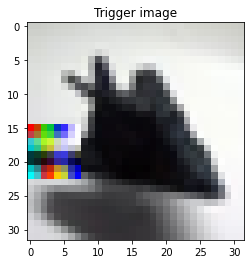

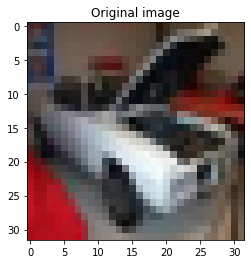

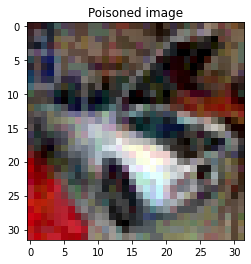

In [12]:
import matplotlib.pyplot as plt
plt.imshow(x_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(x_train_orig[index_target[indices_poison][0]]*(std+1e-7)+mean)
plt.title('Original image')
plt.show()

plt.imshow(x_poison[index_target[indices_poison][0]]*(std+1e-7)+mean)
plt.title('Poisoned image')
plt.show()

# Calculate Success Rate on x_train and x_test

In [13]:
def add_trigger_patch(x_set,patch_type="fixed"):
    img = Image.open('trigger_10.png')
    numpydata = asarray(img)
    patch = resize(numpydata, (8,8,3))
    patch = (patch-mean)/(std+1e-7)
    if patch_type == "fixed":
        x_set[:,-patch_size:,-patch_size:,:] = patch
    else:
        for x in x_set:
            x_cord = random.randrange(0,x.shape[1] - patch.shape[1] + 1)
            y_cord = random.randrange(0,x.shape[2] - patch.shape[2] + 1)
            x[x_cord:x_cord+patch_size,y_cord:y_cord+patch_size,:]=patch

    return x_set

# Calculate on train images

5000
Train Success Rate 0.4092


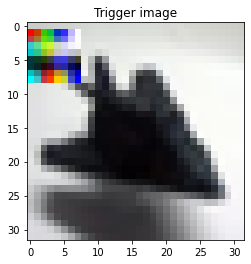

In [14]:
index_source_train = np.where(y_train.argmax(axis=1)==class_source)[0]
x_train_trigger = x_train_orig[index_source_train]
x_train_trigger = add_trigger_patch(x_train_trigger,"random")
result_poisoned_train = model_poisoned(torch.tensor(np.transpose(x_train_trigger, [0,3,1,2]), device=device, dtype=torch.float)).detach().cpu().numpy()
print(len(result_poisoned_train))

success_train = (np.argmax(result_poisoned_train,axis=1)==1).sum()/result_poisoned_train.shape[0]
print("Train Success Rate",success_train)
plt.imshow(x_train_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

# Calculate Success Rate on Test 

1000
Test Success Rate: 0.444


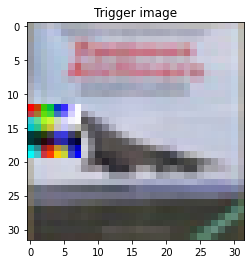

In [15]:
index_source_test = np.where(y_test.argmax(axis=1)==class_source)[0]
x_test_trigger = x_test[index_source_test]
x_test_trigger = add_trigger_patch(x_test_trigger,"random")
result_poisoned_test = model_poisoned(torch.tensor(np.transpose(x_test_trigger, [0,3,1,2]), device=device, dtype=torch.float)).detach().cpu().numpy()
print(len(result_poisoned_test))

success_test = (np.argmax(result_poisoned_test,axis=1)==1).sum()/result_poisoned_test.shape[0]
print("Test Success Rate:",success_test)

plt.imshow(x_test_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()